In [1]:
# data manipulation 
import numpy as np
import pandas as pd

# Time-manipulation libraries:
from datetime import datetime
from time import strftime
import itertools

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Split/Modeling libraries:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# web-based requests
import requests

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

# My functions:
import acquire
import prepare
# import explore - need to complete this soon!

credentials loaded successfully
End of file.


Read df from .csv
Reformatted dates correctly
Set dates as index


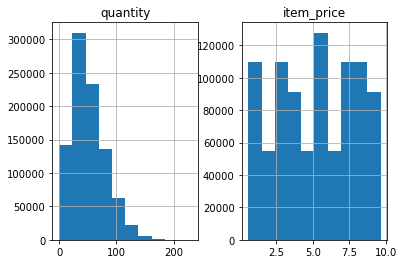

,item,quantity,sale_id,store,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,day,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,1,Tuesday,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,12018 Perrin Beitel Rd,San Antonio,TX,78217,1,Tuesday,218.40
2013-01-01 00:00:00+00:00,46,27.0,832657,7,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664,12018 Perrin Beitel Rd,San Antonio,TX,78217,1,Tuesday,125.55
2013-01-01 00:00:00+00:00,12,54.0,213643,8,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,15000 San Pedro Ave,San Antonio,TX,78232,1,Tuesday,453.60
2013-01-01 00:00:00+00:00,12,35.0,215469,9,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,735 SW Military Dr,San Antonio,TX,78221,1,Tuesday,294.00


In [2]:
df = prepare.prep_store_data()
df.head()

In [5]:
df = pd.read_csv('store_data.csv')
df.head()

,index,item,sale_amount,sale_date,sale_id,store,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


In [6]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [8]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


### Splitting according to the curriculum:

In [9]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [10]:
print(train.shape, validate.shape, test.shape)
print(train.shape[0] + validate.shape[0] + test.shape[0])

(912, 2) (547, 2) (366, 2)
1825


In [11]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [16]:
train.shape[0] + validate.shape[0] + test.shape[0] == df.shape[0]

True

In [12]:
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [13]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [14]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


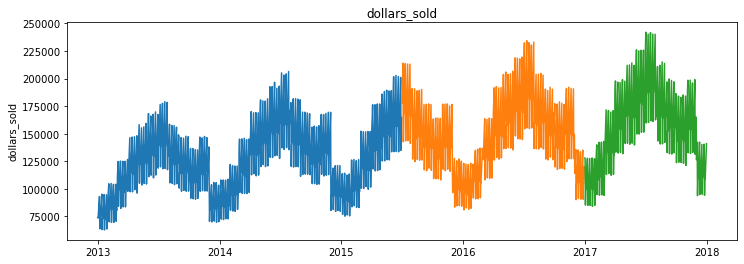

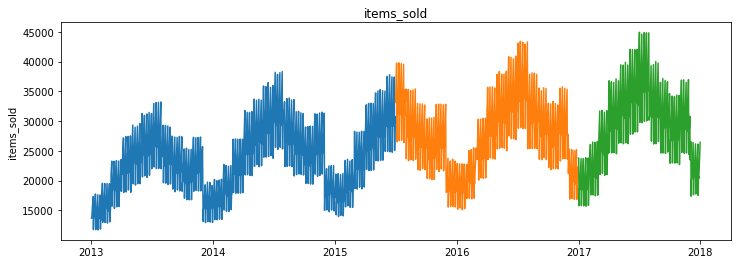

In [15]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Evaluating Root Mean Squared Error and Mean Squared Error:

In [22]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])))
    return rmse
    

In [ ]:
target_var = 'dollars_sold'
rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])))
rmse

In [17]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [18]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [19]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [20]:
eval_df

,model_type,target_var,rmse


In [26]:
dollars = round(train['dollars_sold'][-1:][0], 2)

In [27]:
dollars

164573.2

In [30]:
items = train['items_sold'][-1:][0]
items

30703.0

In [31]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 'items_sold': [items]}, index = validate.index)

yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,164573.2,30703.0
2015-07-03 00:00:00+00:00,164573.2,30703.0
2015-07-04 00:00:00+00:00,164573.2,30703.0
2015-07-05 00:00:00+00:00,164573.2,30703.0
2015-07-06 00:00:00+00:00,164573.2,30703.0


In [32]:
yhat_df.shape

(547, 2)

dollars_sold -- RMSE: 35402


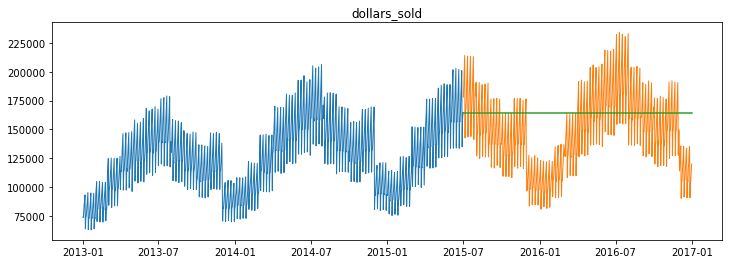

In [33]:
plot_and_eval("dollars_sold")

dollars_sold -- RMSE: 35402


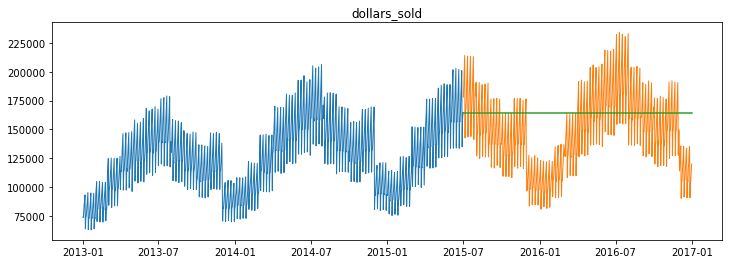

items_sold -- RMSE: 6621


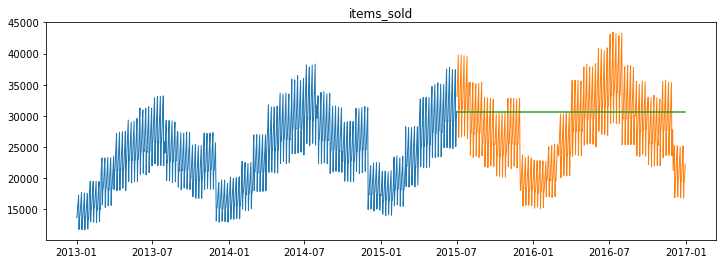

In [34]:
for col in train.columns:
    plot_and_eval(col)

In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [36]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621


## Predicting using Simple Average

#### Make predictions

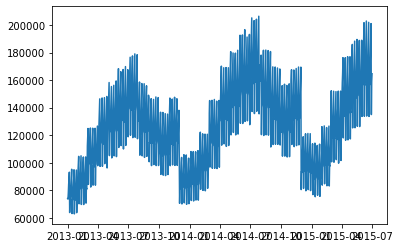

In [42]:
# compute the simple avg first:

plt.plot(train['dollars_sold'])
dollars_pred = round(train['dollars_sold'].mean(), 2)

In [43]:
items_pred = round(train['items_sold'].mean(), 2)
items_pred

23717.94

In [44]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

dollars_sold -- RMSE: 39664


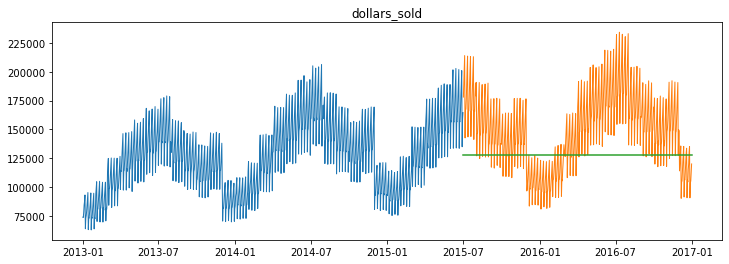

items_sold -- RMSE: 7378


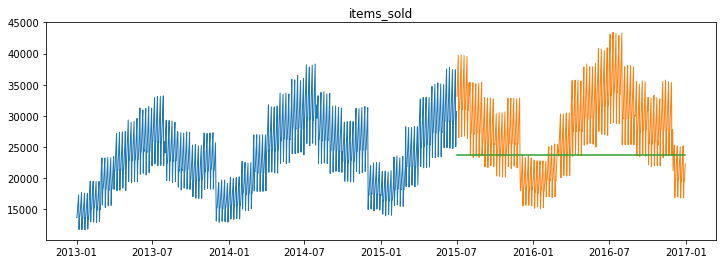

In [45]:
for col in train.columns:
    plot_and_eval(col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_avg', target_var = col)

In [47]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_avg,dollars_sold,39664
3,simple_avg,items_sold,7378


## Moving Average

#### Starting with a 30 day moving average

In [49]:
# setting the period of the moving avg:
period = 30

In [50]:
items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31432.77,168957.91
2015-07-03 00:00:00+00:00,31432.77,168957.91
2015-07-04 00:00:00+00:00,31432.77,168957.91


dollars_sold -- RMSE: 37378


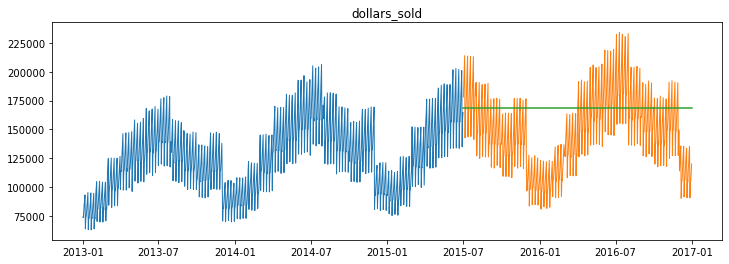

items_sold -- RMSE: 6954


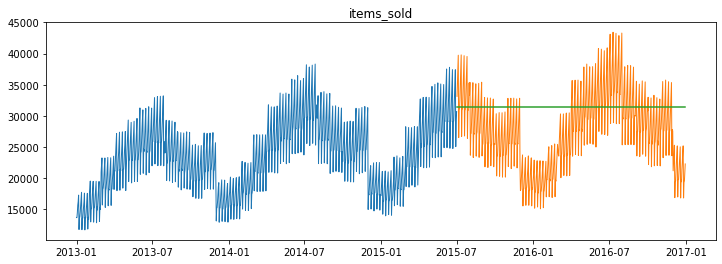

In [51]:
for col in train.columns:
    plot_and_eval(col)

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [57]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    eval_df = append_eval_df(model_type = model_type, target_var = 'items_sold')
    eval_df = append_eval_df(model_type = model_type,
                         target_var = 'dollars_sold'
                        )

In [58]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_avg,dollars_sold,39664
3,simple_avg,items_sold,7378
4,30d moving average,dollars_sold,37378
5,30d moving average,items_sold,6954
6,1d_moving_avg,items_sold,6621
7,4d_moving_avg,items_sold,6592
8,12d_moving_avg,items_sold,6992
9,26d_moving_avg,items_sold,7004


## Holt's Linear Trend

- Weighted Moving Average or an Exponetial Moving Average (EMA).
- Key component to Bollinger Bands

dollars_sold 



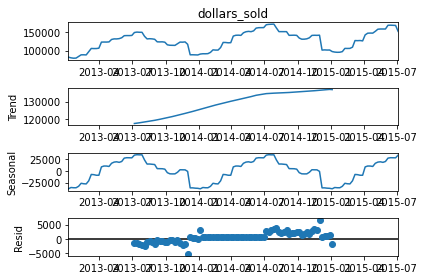

items_sold 



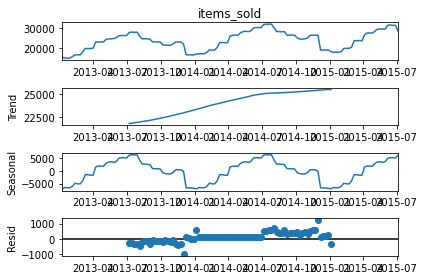

In [60]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

In [65]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


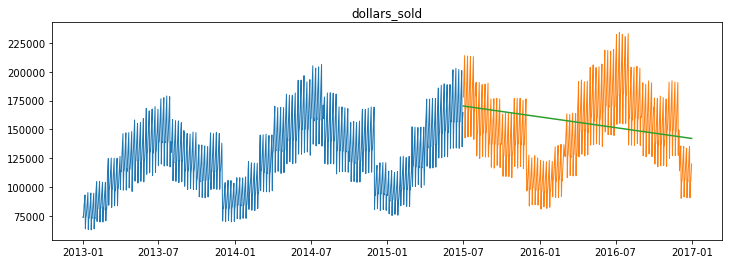

items_sold -- RMSE: 6464


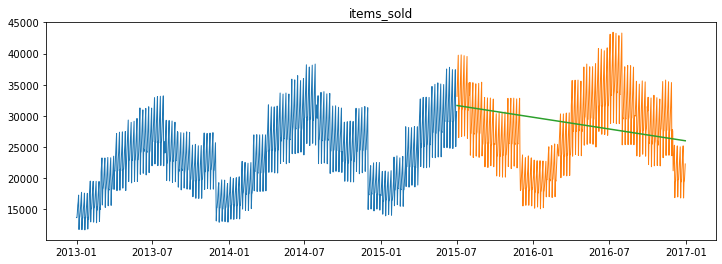

In [66]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [67]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [68]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_avg,dollars_sold,39664
3,simple_avg,items_sold,7378
4,30d moving average,dollars_sold,37378
5,30d moving average,items_sold,6954
6,1d_moving_avg,items_sold,6621
7,4d_moving_avg,items_sold,6592
8,12d_moving_avg,items_sold,6992
9,26d_moving_avg,items_sold,7004


In [69]:
eval_df.sort_values(by = 'rmse')

,model_type,target_var,rmse
22,104d_moving_avg,items_sold,6101
11,104d_moving_avg,items_sold,6101
27,Holts,items_sold,6464
25,Holts,items_sold,6464
10,52d_moving_avg,items_sold,6563
20,52d_moving_avg,items_sold,6563
7,4d_moving_avg,items_sold,6592
14,4d_moving_avg,items_sold,6592
6,1d_moving_avg,items_sold,6621
12,1d_moving_avg,items_sold,6621


In [85]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


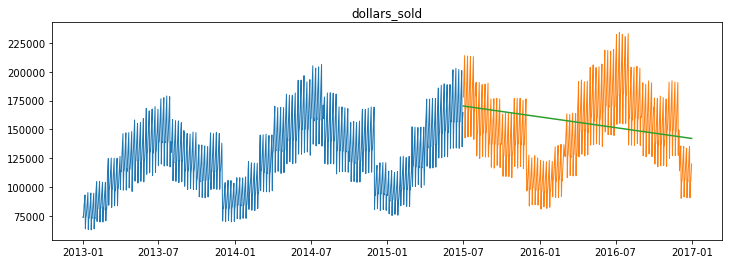

items_sold -- RMSE: 6464


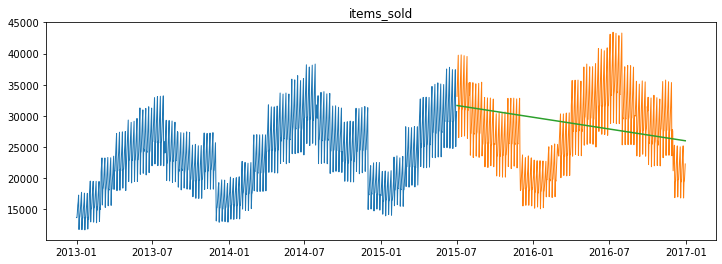

In [86]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [87]:
for col in train.columns:
    eval_df = append_eval_df(model_type = "holts_.1", target_var = col)
    
eval_df.sort_values(by = 'rmse')

,model_type,target_var,rmse
22,104d_moving_avg,items_sold,6101
11,104d_moving_avg,items_sold,6101
29,holts_.1,items_sold,6464
27,Holts,items_sold,6464
25,Holts,items_sold,6464
20,52d_moving_avg,items_sold,6563
10,52d_moving_avg,items_sold,6563
14,4d_moving_avg,items_sold,6592
7,4d_moving_avg,items_sold,6592
1,last_observed_value,items_sold,6621


## Predict based on Previous Cycle

In [91]:
train_cycle = df[:'2015']
validate_cycle = df["2016"]
test_cycle = df["2017"]

In [92]:
train_cycle.shape, validate_cycle.shape, test_cycle.shape

((1095, 2), (365, 2), (365, 2))

### Make predictions

In [94]:
yhat_df = train['2015'] + train.diff(365).mean()
yhat_df

,dollars_sold,items_sold
ds,,
2015-01-01 00:00:00+00:00,106141.021883,19750.056673
2015-01-02 00:00:00+00:00,114674.171883,21243.056673
2015-01-03 00:00:00+00:00,120048.701883,22322.056673
2015-01-04 00:00:00+00:00,127300.161883,23625.056673
2015-01-05 00:00:00+00:00,90355.341883,16759.056673
...,...,...
2015-06-27 00:00:00+00:00,202651.121883,37775.056673
2015-06-28 00:00:00+00:00,214557.471883,39934.056673
2015-06-29 00:00:00+00:00,148486.731883,27598.056673
